# Prelim

## Network

In [2]:
from torch import nn
from torch.nn import functional
import torch
import dgl
from abc import ABC, abstractmethod
from torch import nn
from typing import *
import torch
from copy import deepcopy
import matplotlib as mpl
from matplotlib import cm
from dgl import ops as Fops
from torch.nn import functional as F
import networkx as nx
import numpy as np
import random


def clones(net, N):
    return [deepcopy(net) for _ in range(N)]
    
    
class SizedModule(ABC) :

    @abstractmethod
    def get_size(self) -> int:
        ...
                  
class AddNorm(nn.Module):
    
    def __init__(self, size: Optional[int] = None, dropout: float = 0.1, layer: Optional[SizedModule] = None):
        super().__init__()
        if size is None and layer is None:
            return ValueError("Either size or layer must be provided")
        self.size = size or layer.get_size()
        self.layer = layer
        self.norm = nn.LayerNorm(self.size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, args=None, kwargs=None, layer: Optional[SizedModule] = None):
        kwargs = kwargs or dict()
        if args is None:
            args = (x,)
        layer = layer or self.layer
        return self.norm(x + self.dropout(layer(*args, **kwargs)))
    

    
class MultiHeadAttention(nn.Module):
    
    def __init__(self, dim_model, h):
        super().__init__()
        assert dim_model % h == 0
        self.h = h
        self.dim_model = dim_model
        self.d_k = dim_model // h
        self.linears  = clones(nn.Linear(dim_model, dim_model), 4)
        self.attn = None
    
    def _view_head(self, x):
        return x.view(x.size(0), -1, self.h, self.d_k).transpose(1, 2)
        
    def forward(self, g, query, key, value):
        q = self._view_head(self.linears[0](query))
        k = self._view_head(self.linears[1](key))
        v = self._view_head(self.linears[2](value))
        x = Fops.v_dot_u(g, q, k) / self.d_k**0.5
        score = Fops.edge_softmax(g, x)
#         score = Fops.v_dot_u(g, q, k) / self.d_k**0.5
#         score = F.leaky_relu(Fops.v_dot_u(g, q, k) / self.d_k**0.5)
        out = Fops.u_mul_e_sum(g, v, score)
        out = out.transpose(1, 2).view(g.number_of_nodes(), self.h * self.d_k)
        score = score.view(score.size(0), self.h, -1)
        self.attn = score
        out = self.linears[3](out)
        return out
    
    
class Parallel(nn.Module):
    
    def __init__(self, *modules):
        super().__init__()
        self.mods = nn.ModuleList(modules)
        self.n_modules = len(modules)
        
    def forward(self, x):
        assert x.shape[-1] == len(self.mods)
        out = []
        for i, mod in enumerate(self.mods):
            _x = x[..., i]
            try:
                result = mod(_x)
            except Exception as e:
                msg = "Error found in forward prop of module {}, {}\n".format(i, str(mod)[:1000])
                msg = msg + str(e)
                raise e.__class__(msg)
            out.append(result)
        return torch.cat(out, 1)
    
    
class ParallelEmbedding(Parallel):
    
    def __init__(self, *dims):
        mods = []
        for a, b in dims:
            mods.append(nn.Embedding(a, b))
        super().__init__(*mods)
        
    
class Dense(nn.Module):
    
    def __init__(self, *dims, dropout=0.2):
        super().__init__()
        layers = []
        for a, b in zip(dims[:-1], dims[1:]):
            layers += [nn.Linear(a, b), nn.LeakyReLU(), nn.Dropout(dropout)]
        self.layers = nn.Sequential(*layers)
        
    def __call__(self, x):
        return self.layers(x)

Using backend: pytorch


In [3]:
src_embed = nn.Embedding(10, 16)
dst_embed = nn.Embedding(10, 16)
embed = nn.Embedding(10, 16)

encoder = Dense(17, 16, 16)
attn = AddNorm(16, layer=MultiHeadAttention(16, 16), dropout=0.2)
decoder = Dense(16, 16, 1)

nodes = torch.tensor([0, 1, 2])
target = torch.tensor([[1.33], [1.2], [0.23]])

q = src_embed(nodes)
k = dst_embed(nodes)
x = embed(nodes)
y = target
for i in range(3):
    v = encoder(torch.cat([y, x], 1))
    g = dgl.graph(([0, 1], [2, 2]))
    h = attn(v, args=(g, q, k, v))
    y = decoder(h)

Every node should have a function associated with it that decides its output signal.

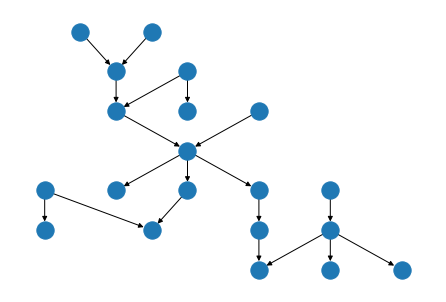

In [4]:
def rand_edge_dir(g, bidirectional_prob: float = 0.):
    dg = nx.DiGraph()
    for n1, n2, edata in g.edges(data=True):
        if random.randint(0, 1) == 0:
            e = (n1, n2)
        else:
            e = (n2, n1)
        dg.add_edge(*e, **edata)
        if bidirectional_prob > 0:
            x = random.random()
            if x < bidirectional_prob:
                dg.add_edge(*list(e)[::-1], **edata)
    return dg


def node_to_node_attr(g, key):
    node_to_idx = {n: i for i, n in enumerate(g.nodes())}
    
    for n, ndata in g.nodes(data=True):
        ndata[key] = node_to_idx[n]

def nor_gate(inputs): 
    if sum(inputs):
        return 0
    else:
        return 1

def and_gate(inputs):
    if 0 in inputs:
        return 0
    else:
        return 1

def gather_inputs(g, n, key):
    inputs = []
    for p in g.predecessors(n):
        ndata = g.nodes()[p]
        inputs.append(ndata[key])
    return inputs

def propogate(g, func_key='fx', key='x', default_value=0):
    for n, ndata in g.nodes(data=True):
        ndata[key] = default_value
    for n in nx.topological_sort(g):
        ndata = g.nodes()[n]
        f = ndata['fx']
        inputs = gather_inputs(g, n, key)
        output = f(inputs)
        ndata[key] = output


g = nx.random_tree(20)
g = rand_edge_dir(g, 0.0)

pos = nx.nx_agraph.pygraphviz_layout(g, prog='dot')
nx.draw(g, pos=pos)
for n, ndata in g.nodes(data=True):
    ndata['fx'] = nor_gate
propogate(g, 'fx', 'x')

## Transforms

In [5]:
from torch.utils.data import Dataset
import typing
from copy import deepcopy
from abc import ABC, abstractmethod

class Transform(typing.Callable):
    
    __inplace__ = None
    
    @abstractmethod
    def forward(self, x):
        ...
        
    def __call__(self, x):
        y = self.forward(x)
        if y is x:
            if not self.__inplace__ is True:
                raise RuntimeError("Transform {} is defined as an out-of-place operation (__inplace__ == False), but found an in-place operation.".format(self))
        else:
            if not self.__inplace__ is False:
                raise RuntimeError("Transform {} is defined as an out-of-place operation (__inplace__ == True), but found an in-place operation.".format(self))
        return y
    
    
class NetworkxToDGL(Transform):
    
    __inplace__ = False
    
    def __init__(self, node_attrs=None, edge_attrs=None):
        self.node_attrs = node_attrs
        self.edge_attrs = edge_attrs
        
    def forward(self, x):
        return dgl.from_networkx(x, node_attrs=self.node_attrs, edge_attrs=self.edge_attrs)

    
class DGLFullyConnected(Transform):
    
    __inplace__ = True
    
    @staticmethod
    def leading_zero(x):
        yield torch.zeros_like(x[0])
        yield from x
        
    @classmethod
    def get_complete_edges(cls, g):
        x = torch.cumsum(g.batch_num_nodes(), 0)
        all_edges = []
        for a, b in zip(cls.leading_zero(x), x):
            edges = torch.combinations(torch.arange(a, b))
            all_edges.append(edges)
        return torch.cat(all_edges, 0).T

    @classmethod
    def add_complete_edges(cls, g):
        n1 = g.number_of_nodes()
        edges = cls.get_complete_edges(g)
        g.add_edges(edges[0], edges[1])
        g.add_edges(edges[1], edges[0])
        n2 = g.number_of_nodes()
        assert n1 == n2
        return g
    
    def forward(self, g):
        self.add_complete_edges(g)
        return g

    
class Compose(Transform):
    
    def __init__(self, *transforms):
        self.transforms = transforms
        for t in transforms:
            if hasattr(t.__inplace__) and t.__inplace__ is True:
                self.__inplace__ = True
                break
        
    def forward(self, x):
        for transform in self.transforms:
            x = transform(x)
        return x
    
    
class Deepcopy(Transform):
    
    __inplace__ = False
    
    """Perform a deepcopy as not to modify original dataset"""
    def forward(self, x):
        return deepcopy(x)

## Datasets

In [6]:
class Cache(object):
    
    ...
    
class SplitDataset(Dataset):
    
    def __init__(self, data, transforms=None):
        """Basic dataset with `split` function and transforms"""
        self.data = data
        self.transforms = transforms
        self.warnings()

    def warnings(self):
        hasdeepcopy = False
        for t in self.transforms:
            if t.__class__.__name__.lower() == 'deepcopy':
                hasdeepcopy = True
            if hasattr(t, '__inplace__') and t.__inplace__ is True:
                if not hasdeepcopy:
                    print("Warning: transforms have inplace operations that do not follow a deepcopy operation. This " +
                          "may cause modifications to the original dataset.\nOffending transform: {}".format(t))
                    break
        
    def apply_transforms(self, x, transforms):
        if transforms:
            if isinstance(transforms, (list, tuple)):
                for t in transforms:
                    x = t(x)
            elif callable(transforms):
                x = transforms(x)
            else:
                raise TypeError("Transforms must be callable or an list or tuple of callables")
        return x
        
        
    def transform(self, x, idx):
        return self.apply_transforms(x, self.transforms)

    def __getitem__(self, idx):
        return self.transform(self.data[idx], idx)

    def split(self, *splits):
        x = torch.tensor(splits)
        x = torch.cumsum(x, 0) / x.sum()

        idx = len(self) * x
        idx = [0] + idx.long().tolist()
        idx[-1] = None
        idx[0] = None
        datasets = []
        for i, j in zip(idx[:-1], idx[1:]):
            datasets.append(self.__class__(self.df.iloc[i:j], transforms=self.transforms))
        return datasets
    
    def __len__(self):
        return len(self.data)
    
class CachedDataset(SplitDataset):
    
    def __init__(self, data, transforms=None):
        """Cached dataset. Simply add `Cache()` in the transforms at the location 
        where you want the data to be cached. If modifications follow `Cache()`
        it is recommended you add `Deepcopy()` immediately after the `Cache()` transform.
        
        For example, we may want to cache the dgl graph creation (expensive) and then perform
        additional graph modifications: 
        
        .. code-block::
        
            dataset = CachedDataset(graphs, transforms=[
                NetworkxToDGL(),
                Cache(),
                Deepcopy(),
                DGLFullyConnected(),
            ])
        """
        self.cache = {}
        self._cache_at = None
        if transforms:
            for i, t in enumerate(transforms):
                if isinstance(t, Cache):
                    self._cache_at = i
                    break
        if isinstance(transforms, tuple):
            transforms = list(transforms)
        elif not isinstance(transforms, list):
            transforms = [transforms]
        
        super().__init__(data, transforms=transforms)
        
          
    def transform(self, x, idx):
        cached_transforms = self.transforms[:self._cache_at]
        other_transforms = self.transforms[self._cache_at+1:]
        
        if idx not in self.cache:
            x = self.apply_transforms(x, cached_transforms)
            self.cache[idx] = x
    
        x = self.apply_transforms(x, other_transforms)
        return x
        
    def __getitem__(self, idx):
        x = self.data[idx]
        out = self.transform(x, idx)
        return out
        
    
def generate_graph():
    g = nx.random_tree(20)
    g = rand_edge_dir(g, 0.0)
    for n, ndata in g.nodes(data=True):
        ndata['fx'] = nor_gate
    propogate(g, 'fx', 'x')
    return g

graphs = [generate_graph() for _ in range(100)]

dataset = CachedDataset(graphs, transforms=[
    NetworkxToDGL(),
    Cache(),
    Deepcopy(),
    DGLFullyConnected(),
])

print(dataset[0])
print(dataset.cache)

Graph(num_nodes=20, num_edges=399,
      ndata_schemes={}
      edata_schemes={})
{0: Graph(num_nodes=20, num_edges=19,
      ndata_schemes={}
      edata_schemes={})}


## Utils

In [7]:
def one_hot(x: torch.Tensor, num_classes: int, device=None, dtype=torch.long):
    to_shape = None
    if len(x.shape) > 1:
        to_shape = tuple(x.shape) + (num_classes,)
        x = x.flatten()
    b = torch.zeros(x.shape[0], num_classes, device=device, dtype=dtype)
    b[torch.arange(x.shape[0], device=device), x.to(device)] = 1
    if to_shape:
        b = b.view(to_shape)
    return b

# Experiments

## Experiment 1: Linkage Prediction using Attention

In this brief experiment, we try learn embedding such that we can predict the original adjacency matrix. This will prove that we can use attention-like mechanisms to learn node embeddings that capture a graph.

**Results**

The most important thing we learn from this is that the initial encoding size must be large as it is mainly a memorization procedure. Initial encoding must be large enough to evaluate all 400 connetions. In this regard, depths *is not important* assuming the encodings are fairly simple.

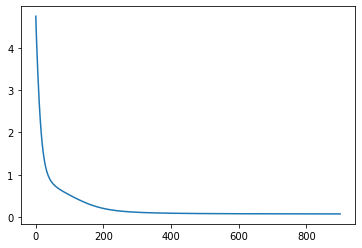

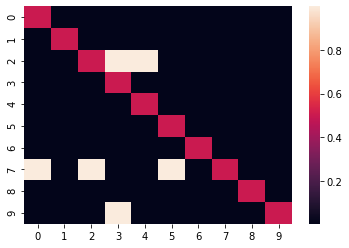

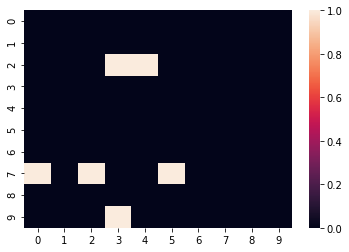

100%|██████████| 1000/1000 [00:06<00:00, 156.96it/s]


In [8]:
from tqdm import tqdm
from matplotlib import pylab as plt
import seaborn as sns
from IPython import display


def randnxg():
    n_edges = 10
    n_types = 20
    n_edges_per_graph = (2, 50)
    n_graphs = 10
    g = nx.DiGraph()

    for i in range(10):
        n_inputs = torch.randint(2, 3, (1,))
        n_outputs = torch.randint(1, 2, (1,))
        inputs = torch.randint(0, n_types, (n_inputs,))
        outputs = torch.randint(0, n_types, (n_outputs,))
        g.add_node(i, inputs=inputs, outputs=outputs)

    for n, ndata in g.nodes(data=True):
        for n2, ndata2 in g.nodes(data=True):
            for i in ndata['outputs']:
                if i in ndata2['inputs']:
                    g.add_edge(n, n2)

    for n, ndata in g.nodes(data=True):
        i = one_hot(ndata['inputs'], n_types).sum(0)
        o = one_hot(ndata['outputs'], n_types).sum(0)
        ndata['x'] = torch.cat([i, o])
    return g


class AdjPredNetwork(nn.Module):
    
    def __init__(self, d_model, *h):
        super().__init__()
        self.d_model = d_model
        self.src_encoder = Dense(d_model, *h, dropout=0.2)
        self.dst_encoder = Dense(d_model, *h, dropout=0.2)
        self.decoder = nn.Sigmoid()
        
    def forward(self, x):
        q = self.src_encoder(x)
        k = self.dst_encoder(x)
        adj = torch.matmul(q, k.T) * (1 - torch.eye(q.shape[0]))
        return self.decoder(adj)

nxg = randnxg()

g = dgl.from_networkx(nxg, node_attrs=['x'])

net = AdjPredNetwork(40, 1028)
optim = torch.optim.AdamW(net.parameters())
lossfn = nn.BCELoss()
losses = []
for i in tqdm(range(1000)):
    g = dgl.from_networkx(nxg, node_attrs=['x'])
    y = net(g.ndata['x'].float())
    y_hat = g.adjacency_matrix().to_dense()
    loss = lossfn(y.flatten(), y_hat.flatten())
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    losses.append(loss.detach().item())
    
    if i % 100 == 0:
        net.eval()
        display.clear_output(wait=True)
        plt.plot(losses)
        plt.show()
        g = dgl.from_networkx(nxg, node_attrs=['x'])
        g = dgl.from_networkx(nxg, node_attrs=['x'])
        y = net(g.ndata['x'].float())
        y_hat = g.adjacency_matrix().to_dense()
        sns.heatmap(y.detach())
        plt.show()
        sns.heatmap(y_hat)
        plt.show()



## Experiment 2: Prediction of Computation Graph

In this experiment we try to predict the behavior of a graph the characterizes NOR circuits.

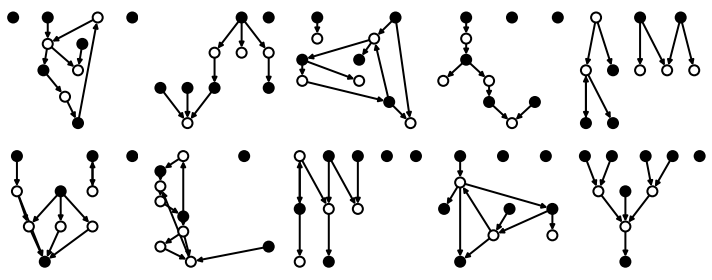

In [9]:
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

g = randnxg()

for n, ndata in g.nodes(data=True):
    ndata['fx'] = nor_gate

def gen_nor_circuit():
    g = randnxg()
    for n, ndata in g.nodes(data=True):
        ndata['fx'] = nor_gate
    propogate(g, key='y')
    return g

def propogate(g, func_key='fx', key='result', default_value=0):
    for n, ndata in g.nodes(data=True):
        ndata[key] = default_value
    for i in range(10):
        for n in g.nodes():
            ndata = g.nodes()[n]
            f = ndata['fx']
            inputs = gather_inputs(g, n, key)
            output = f(inputs)
            ndata[key] = output
            
            
            
def plot_binary_graph(g, cmap=cm.binary, ax=None, key='y', **kwargs):
    # cmap = cm.get_cmap('plasma')(np.linspace(0, 1, 255))     
    x = np.array([ndata[key] for n, ndata in g.nodes(data=True)])
    node_colors = cmap(x*255)
    pos = nx.nx_agraph.pygraphviz_layout(g, prog='dot')
    nx.draw(g, pos=pos, node_color=node_colors, ax=ax, width=2, edgecolors='k', linewidths=2., **kwargs)

    
graphs = []
for i in range(10):
    g = gen_nor_circuit()
    graphs.append(g)
    
# generate some random data
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, g in zip(axes.flatten(), graphs):
    plot_binary_graph(g, ax=ax, node_size=100)
plt.tight_layout()

### Message Passaging Network

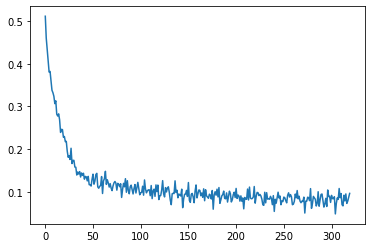

100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


In [10]:
from dgl import function as fn
from torch.utils.data import DataLoader


class CircuitNetwork(nn.Module):
    
    def __init__(self, d_model, h):
        super().__init__()
        self.encoder = Dense(d_model, h, h)
        self.core = nn.Sequential(
            Dense(h, h, h),
            nn.LayerNorm(h)
        )
        self.decoder = nn.Sequential(
            Dense(h, h, h),
            nn.Linear(h, 1),
#             nn.Sigmoid()
        )
        
    def forward(self, g, x):
        
        with g.local_scope():
            g.ndata['h'] = self.encoder(x)
            for i in range(3):
                g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
                g.ndata['h'] = self.core(g.ndata['h'])
            return self.decoder(g.ndata['h'])

def create_loader(n=1000, batch_size=32):
    graphs = [gen_nor_circuit() for i in range(n)]
    dataset = SplitDataset(graphs, transforms=[
        NetworkxToDGL(node_attrs=['x', 'y']),
    ])
    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=dgl.batch)
    return dataset, loader


def train_circuit_network(net, epochs=1000, batch_size=32):
    dataset, loader = create_loader(batch_size=batch_size)
    for g in loader:
        ...
    net(g, g.ndata['x'].float())



    optim = torch.optim.AdamW(net.parameters())
    lossfn = nn.MSELoss()

    def compute_loss(g, net):
        y = net(g, g.ndata['x'].float())
        y_hat = g.ndata['y'].float()
        loss = lossfn(y.flatten(), y_hat.flatten())
        return loss

    losses = []
    for i in tqdm(range(epochs)):
        for g in loader:
            loss = compute_loss(g, net)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.detach().item())

        if i % 3 == 0:
            display.clear_output(wait=True)
            plt.plot(losses)
            plt.show()
            
net = CircuitNetwork(40, 32)
train_circuit_network(net, epochs=10)


### AutoEncoder Network V1

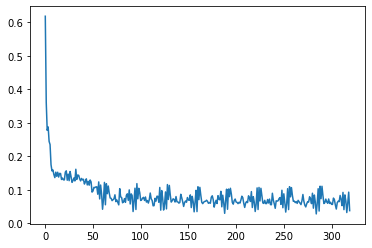

100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


In [15]:
class AutoEncoderCircuitNetwork(nn.Module):
    
    def __init__(self, d_model, h):
        super().__init__()
        self.encoder = Dense(d_model, h, h)
        self.inner_encoder = Dense(h+1, h, h)
        self.core = nn.Sequential(
            Dense(h, h, h),
            nn.LayerNorm(h)
        )
        self.decoder = nn.Sequential(
            Dense(h, h, h),
            nn.Linear(h, 1),
#             nn.Sigmoid()
        )
        self.out_arr = []
        
    def forward(self, g, x, n=5):
        out_arr = []
        with g.local_scope():
            x = torch.ones_like(x)
            g.ndata['e'] = self.encoder(x)
            g.ndata['x'] = torch.ones((g.number_of_nodes(), 1))
            for i in range(n):
                x = torch.cat([g.ndata['e'], g.ndata['x']], 1)
                g.ndata['h'] = self.inner_encoder(x)
                g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = self.decoder(g.ndata['h'])
                g.ndata['x'] = out
#                 g.update_all(fn.copy_u('x', 'm'), fn.sum('m', 'x'))
                out_arr.append(out)
        self.out_arr = out_arr
        return out
        
net = AutoEncoderCircuitNetwork(40, 128)
train_circuit_network(net, epochs=11)

In [172]:
g.update_all(fn.copy)

Graph(num_nodes=10, num_edges=7,
      ndata_schemes={'x': Scheme(shape=(40,), dtype=torch.int64), 'y': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

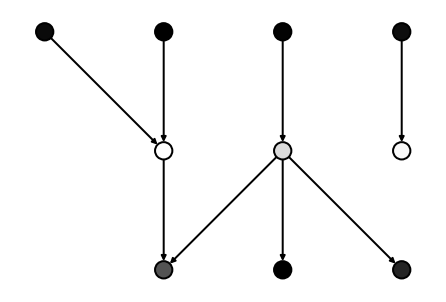

In [12]:


def plot_binary_graph(g, cmap=cm.binary, ax=None, key='y', **kwargs):
    # cmap = cm.get_cmap('plasma')(np.linspace(0, 1, 255))     
    x = np.array([ndata[key] for n, ndata in g.nodes(data=True)])
    node_colors = cmap(x)
    pos = nx.nx_agraph.pygraphviz_layout(g, prog='dot')
    nx.draw(g, pos=pos, node_color=node_colors, ax=ax, width=2, edgecolors='k', linewidths=2., **kwargs)
    

dataset, loader = create_loader(20)

g = dataset[0]
with g.local_scope():
    net(g, g.ndata['x'].float(), n=10)
    g.ndata['out'] = torch.cat(net.out_arr, 1)
    nxg = nx.DiGraph(g.to_networkx(node_attrs=['out', 'x']))
    for n, ndata in nxg.nodes(data=True):
        ndata['j'] = ndata['out'][9].item()
    plot_binary_graph(nxg, key='j')



#### Response Function

In [88]:
from IPython import display

%matplotlib inline

nxg = nx.DiGraph()
nxg.add_edge(0, 2)
nxg.add_edge(1, 2)
g = dgl.from_networkx(nxg)

def forward(self, g, mod, n=5):
    x = torch.ones((g.number_of_nodes(), 40))
    out_arr = []
    with g.local_scope():
        g.ndata['e'] = self.encoder(x)
        g.ndata['x'] = torch.ones((g.number_of_nodes(), 1))
        for i in range(n):
            g.ndata['x'] = mod(g.ndata['x'])
            x = torch.cat([g.ndata['e'], g.ndata['x']], 1)
            g.ndata['h'] = self.inner_encoder(x)
            g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
            g.ndata['h'] = self.core(g.ndata['h'])
            out = self.decoder(g.ndata['h'])
            g.ndata['x'] = out
#                 g.update_all(fn.copy_u('x', 'm'), fn.sum('m', 'x'))
            out_arr.append(out)
    self.out_arr = out_arr
    return out

z_arr = []
x = torch.linspace(0, 1, 10)
y = torch.linspace(0, 1, 10)

X = []
Y = []
for i in x:
    for j in y:
        X.append(i)
        Y.append(j)
        def mod(x):
            x[0] = i
            x[1] = j
            return x
        
        out = forward(net, g, mod)
        z_arr.append(out[-1])
Z = torch.cat(z_arr).detach()
ax = plt.axes(projection='3d')
X = torch.stack(X)
Y = torch.stack(Y)
ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='k')
ax.view_init(25, 30)
plt.show()

AttributeError: 'AutoEncoderCircuitNetwork2' object has no attribute 'inner_encoder'

In [179]:
torch.clamp?

Docstring:
clamp(input, min, max, *, out=None) -> Tensor

Clamp all elements in :attr:`input` into the range `[` :attr:`min`, :attr:`max` `]`.
Let min_value and max_value be :attr:`min` and :attr:`max`, respectively, this returns:

.. math::
    y_i = \min(\max(x_i, \text{min\_value}), \text{max\_value})


Args:
    input (Tensor): the input tensor.
    min (Number): lower-bound of the range to be clamped to
    max (Number): upper-bound of the range to be clamped to

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> a = torch.randn(4)
    >>> a
    tensor([-1.7120,  0.1734, -0.0478, -0.0922])
    >>> torch.clamp(a, min=-0.5, max=0.5)
    tensor([-0.5000,  0.1734, -0.0478, -0.0922])

.. function:: clamp(input, *, min, out=None) -> Tensor

Clamps all elements in :attr:`input` to be larger or equal :attr:`min`.

Args:
    input (Tensor): the input tensor.

Keyword args:
    min (Number): minimal value of each element in the output
    out (Tensor, optional)

### Autoencoder Network V2

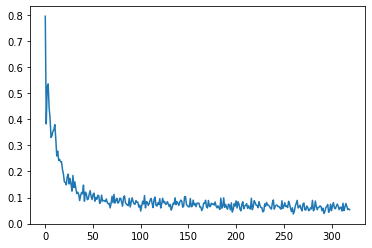

100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


In [200]:
class AutoEncoderCircuitNetwork2(nn.Module):
    
    def __init__(self, d_model, h):
        super().__init__()
        self.encoder = Dense(d_model, h, h, h)
        self.x_init = nn.Linear(1, 1)
        self.core = nn.Sequential(
            Dense(h+1, h, h, h, h),
            nn.LayerNorm(h)
        )
        self.decoder = nn.Linear(h, 1)
        self.out_arr = []
        
    def forward(self, g, x, n=5):
        out_arr = []
        with g.local_scope():
            
            g.ndata['e'] = self.encoder(x)
            g.ndata['x'] = self.x_init(torch.zeros((g.number_of_nodes(), 1)))
            for i in range(n):
                g.update_all(fn.copy_u('x', 'm'), fn.max('m', 'x'))
                g.ndata['h'] = torch.cat([g.ndata['e'], g.ndata['x']], 1)
                g.ndata['h'] = self.core(g.ndata['h'])
                out = self.decoder(g.ndata['h'])
                out = torch.clamp(out, 0.)
                g.ndata['x'] = out
                out_arr.append(out)
        self.out_arr = out_arr
        return out
        
net = AutoEncoderCircuitNetwork2(40, 128)
train_circuit_network(net, epochs=11)

In [196]:
dataset, loader = create_loader(20)

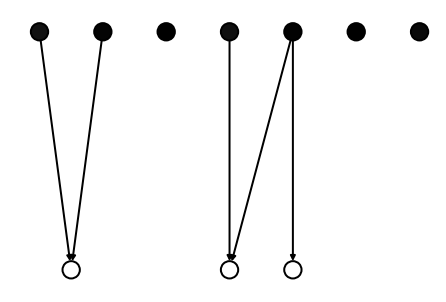

In [197]:
g = dataset[2]
with g.local_scope():
    net(g, g.ndata['x'].float(), n=10)
    g.ndata['out'] = torch.cat(net.out_arr, 1)
    nxg = nx.DiGraph(g.to_networkx(node_attrs=['out', 'x']))
    for n, ndata in nxg.nodes(data=True):
        ndata['j'] = ndata['out'][3].item()
    plot_binary_graph(nxg, key='j')

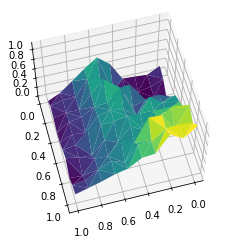

In [226]:
from IPython import display
%matplotlib inline

nxg = nx.DiGraph()
nxg.add_edge(0, 2)
nxg.add_edge(1, 2)
nxg.add_edge(2, 3)
nxg.add_edge(0, 3)
g = dgl.from_networkx(nxg)

def forward(self, g, mod, n=5):
    x = torch.ones((g.number_of_nodes(), 40))
    out_arr = []
    with g.local_scope():

        g.ndata['e'] = self.encoder(x)
        g.ndata['x'] = self.x_init(torch.zeros((g.number_of_nodes(), 1)))
        for i in range(n):
            g.ndata['x'] = mod(g.ndata['x'])
            g.update_all(fn.copy_u('x', 'm'), fn.max('m', 'x'))
            g.ndata['h'] = torch.cat([g.ndata['e'], g.ndata['x']], 1)
            g.ndata['h'] = self.core(g.ndata['h'])
            out = self.decoder(g.ndata['h'])
            out = torch.clamp(out, 0.)
            g.ndata['x'] = out
            out_arr.append(out)
    self.out_arr = out_arr
    return out
   
z_arr = []
x = torch.linspace(0, 1, 10)
y = torch.linspace(0, 1, 10)

X = []
Y = []
for i in x:
    for j in y:
        X.append(i)
        Y.append(j)
        def mod(x):
            x[0] = i
            x[1] = j
            return x
        
        out = forward(net, g, mod)
        z_arr.append(out[-1])
Z = torch.cat(z_arr).detach()
ax = plt.axes(projection='3d')
X = torch.stack(X)
Y = torch.stack(Y)
ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')
ax.view_init(60, 45+30)
plt.show()

### AutoEncoder Network V3

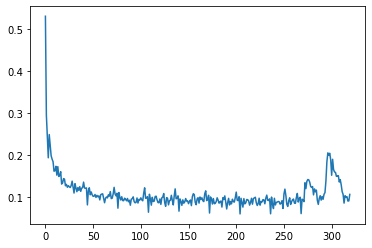

100%|██████████| 11/11 [00:27<00:00,  2.51s/it]


In [37]:
class AutoEncoderCircuitNetwork3(nn.Module):
    
    def __init__(self, d_model, h):
        super().__init__()
        self.encoder = Dense(d_model, h, h, h)
        self.x_init = nn.Linear(1, 1)
        self.core = nn.Sequential(
            Dense(h+1, h, h, h, h),
            nn.LayerNorm(h)
        )
        self.edge_core = nn.Sequential(
            Dense(h+1, h+1),
            nn.LayerNorm(h+1)
        )
        self.decoder = nn.Linear(h, 1)
        self.out_arr = []
        
    def forward(self, g, x, n=10):
        out_arr = []
        with g.local_scope():
            
            g.ndata['e'] = self.encoder(x)
            g.ndata['x'] = self.x_init(torch.ones((g.number_of_nodes(), 1)))
            for i in range(n):
                g.update_all(fn.copy_u('x', 'm'), fn.sum('m', 'x'))
                
                g.ndata['h'] = torch.cat([g.ndata['e'], g.ndata['x']], 1)
                g.apply_edges(fn.u_mul_v('h', 'h', 'h'))
                g.edata['h'] = self.edge_core(g.edata['h'])
                g.update_all(fn.u_add_e('h', 'h', 'm'), fn.sum('m', 'h'))
                g.ndata['h'] = self.core(g.ndata['h'])
                out = self.decoder(g.ndata['h'])
                g.ndata['x'] = out + g.ndata['x']
                out_arr.append(out)
        self.out_arr = out_arr
        return out
        
net = AutoEncoderCircuitNetwork3(40, 128)
train_circuit_network(net, epochs=11)

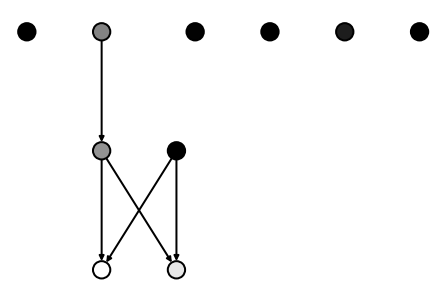

In [38]:
g = dataset[10]
with g.local_scope():
    net(g, g.ndata['x'].float(), n=10)
    g.ndata['out'] = torch.cat(net.out_arr, 1)
    nxg = nx.DiGraph(g.to_networkx(node_attrs=['out', 'x']))
    for n, ndata in nxg.nodes(data=True):
        ndata['j'] = ndata['out'][1].item()
    plot_binary_graph(nxg, key='j')

### Recurrent Network

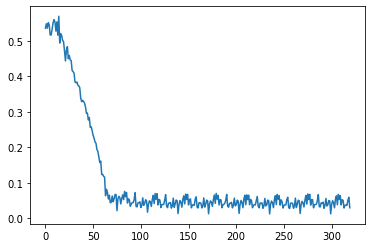

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


In [41]:
from functools import partial

def init_data(n, min_nodes=2, max_nodes=20, to_batch=False):
    nxgraphs = sigmoid_circuit(n, min_nodes, max_nodes)

    for g in nxgraphs:
        for n, ndata in g.nodes(data=True):
            ndata['v'] = np.array([0.], dtype=np.float32)
        for n1, n2, edata in g.edges(data=True):
            edata['e'] = np.array([0.], dtype=np.float32)
    graphs = [dgl.from_networkx(g, node_attrs=['v', 'target'], edge_attrs=['e']) for g in nxgraphs]    
    if to_batch:
        return dgl.batch(graphs)
    return graphs

class Dense(nn.Module):
    
    def __init__(self, *latent_sizes, layer_norm=False): 
        super().__init__()
        layers = []
        for l1, l2 in zip(latent_sizes[:-1], latent_sizes[1:]):
            _layers = [
                nn.Linear(l1, l2),
                nn.LeakyReLU()
            ]
            if layer_norm:
                _layers.append(nn.BatchNorm1d(l2))
            layers.append(nn.Sequential(*_layers))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder(nn.Module):
    
    def __init__(self, a_list, b_list):
        super().__init__()
        self.encoder_a = Dense(*a_list)
        self.encoder_b = Dense(*b_list)
        
    def forward(self, x, hold=None):
        a = self.encoder_a(x)
        if hold is not None:
            a = hold(a)
        b = self.encoder_b(x)
        c = torch.cat([a, b], 1)
        return a, b, c
        

class GraphCell(nn.Module):
    """... with disentablement"""
    def __init__(self, a, b):
        super().__init__()
        self.dense = Dense(a, b, layer_norm=False)
#         self.gru = nn.GRUCell(a, b)
        self.autoencoder = Encoder([b, b, b, 1], [b, b, b-1])
        self.decoder = Dense(b-1, b-1, 1)
#         self.autoencoder = AdversarialAE(b, [b, 1], [b, b-1], [b], [b])
            
    def forward(self, a, b, hold=None):
#         x = self.gru(a, b)
        x = self.dense(a)
        a, b, x = self.autoencoder(x, hold=hold)
        a_hat = self.decoder(b)
        return x, a, a_hat
        

class RGNNAAE(nn.Module):
    """Recurrent graph neural network with adversarial autoencoder"""
    def __init__(self, node_hidden_size):
        super().__init__()
        
        # Setting from the paper
        self.node_activation_hidden_size = 2 * node_hidden_size
        self.gru = GraphCell(self.node_activation_hidden_size, node_hidden_size)
    
        gru_init = lambda: GraphCell(self.node_activation_hidden_size,
                           node_hidden_size)
#         msg_init = lambda: nn.Linear(2 * node_hidden_size + 1,
#                                            self.node_activation_hidden_size)
        msg_init = lambda: nn.Sequential(
            nn.Linear(2 * node_hidden_size + 1, self.node_activation_hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.node_activation_hidden_size, self.node_activation_hidden_size)
        )
        self.message_func = msg_init()
        self.node_update_func = gru_init()
        self.reduce_func = self.dgmg_reduce
        self.encode = nn.Linear(1, node_hidden_size)
        self.decode = nn.Linear(node_hidden_size, 1)

    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {'m': torch.cat([edges.src['hv'],
                                edges.data['he']],
                               dim=1)}

    def dgmg_reduce(self, nodes):
        hv_old = nodes.data['hv']
        m = nodes.mailbox['m']
        message = torch.cat([
            hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2)
        node_activation = (self.message_func(message)).sum(1)
        return {'a': node_activation}

    def forward(self, g, x, n=10, hold=None):
        num_prop_rounds = n
        with g.local_scope():
            g.ndata['v'] = torch.ones((g.number_of_nodes(), 1))
            g.edata['e'] = torch.ones((g.number_of_edges(), 1))
            g.ndata['hv'] = self.encode(g.ndata['v'])
            g.edata['he'] = g.edata['e']

            steps = []
            out_arr = []
            if g.number_of_edges() > 0:
                for t in range(num_prop_rounds):
                    g.update_all(message_func=self.dgmg_msg,
                                reduce_func=self.reduce_func)
                    hv, out, out_hat = self.node_update_func(g.ndata['a'], g.ndata['hv'], hold=hold)
                    g.ndata['out'] = out
                    g.ndata['out_hat'] = out_hat
                    g.ndata['hv'] = torch.clamp(hv, 0)
                    steps.append(
                        {
                            'out': g.ndata['out'],
                            'out_hat': g.ndata['out_hat'],
                            'hv': g.ndata['hv']
                        }
                    )
                    out_arr.append(g.ndata['out'])
            self.out_arr = out_arr
            return g.ndata['out']
    
torch.set_default_dtype(torch.float32)
net = RGNNAAE(32)

train_circuit_network(net, epochs=10)

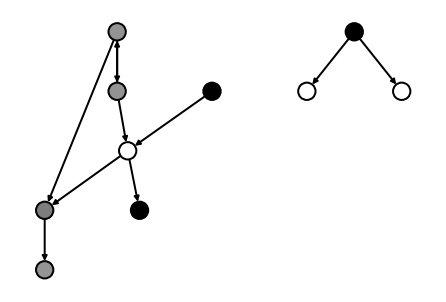

In [53]:
g = dataset[5]
with g.local_scope():
    net(g, g.ndata['x'].float(), n=10)
    g.ndata['out'] = torch.cat(net.out_arr, 1)
    nxg = nx.DiGraph(g.to_networkx(node_attrs=['out', 'x']))
    for n, ndata in nxg.nodes(data=True):
        ndata['j'] = ndata['out'][5].item()
    plot_binary_graph(nxg, key='j')

TODO: what makes the above network so much better than the other networks?

1. There is a dense layer immediately before the summation operation
2. We pass hidden features, for `hv` we concatenate and sum old and new value
3. We don't seem to ever update `he` ...
4. We clamp hv.
5. We have two independent encoder/decoders, one for `hv` and one for `out`

### Experiment 3.5: Stochastic prediction

## Experiment 3: Prediction of Computation Graph using Attention

In this experiment, we try to learn a computation graph without knowing the interactions beforehand. We combine attention and graph propogation to accomplish this.

In [1]:
g.edges()

NameError: name 'g' is not defined

## Experiment 4: Prediction of Stochastic Computation Graph using Attention